In [1]:
import sys
sys.path.append('..//')

import jax
import numpy as np
import jax.numpy as jnp
from jax import jacfwd, jacrev
import matplotlib.pyplot as plt
import jax.scipy.linalg as jlinalg

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

from parsmooth import MVNStandard
from parsmooth import FunctionalModel
from parsmooth.sequential._filtering import filtering
from parsmooth.sequential._smoothing import smoothing
from parsmooth.methods import iterated_smoothing
from parsmooth.linearization import extended, extended_hessian
from parsmooth.sequential._filtering_Newton import filtering as newton_filtering
from parsmooth.sequential._smoothing_Newton import smoothing as newton_smoothing
from bearing_data import get_data, make_parameters
from bearing_data_pe import inverse_bearings

In [2]:
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step

T = 500
_, true_states, ys = get_data(x0, dt, r, T, s1, s2)

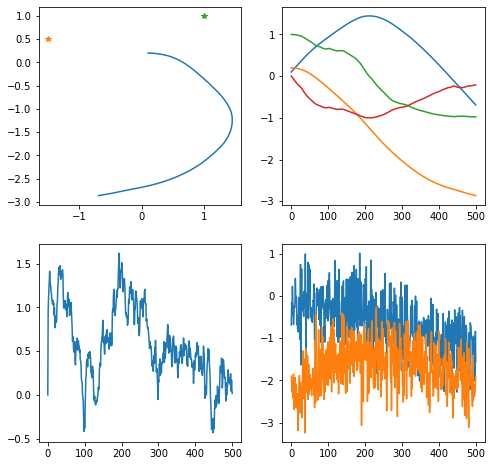

In [3]:
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.plot(true_states[:,0], true_states[:,1])
plt.plot(s1[0],s1[1], '*')
plt.plot(s2[0],s2[1], '*')
plt.subplot(2, 2, 2)
plt.plot(true_states[:,0:-1])
plt.subplot(2, 2, 3)
plt.plot(true_states[:,-1])
plt.subplot(2, 2, 4)
plt.plot(ys);

In [4]:
qc = 0.01  # discretization noise
qw = 10  # discretization noise
Q, R, observation_function, transition_function, observation_function_dx, transition_function_dx = make_parameters(qc, qw, r, dt, s1, s2)

chol_Q = jlinalg.cholesky(Q, lower=True)
chol_R = jlinalg.cholesky(R, lower=True)

m0 = jnp.array([0., 0., 1., 0., 0.])
P0 = jnp.diag(jnp.array([0.1, 0.1, 1., 1., 1.]))

# m0 = transition_function(jnp.array([0.1, 0.2, 1, 0, 0]) )
# P0 = Q

init = MVNStandard(m0, P0)

positions = inverse_bearings(ys, s1, s2)
states = jnp.concatenate([jnp.concatenate([jnp.zeros((1,2)), positions], axis = 0),
                          jnp.zeros((T+1,3))], axis = 1)

initial_states =  MVNStandard(states,jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))

# initial_states =  MVNStandard(jnp.repeat(jnp.array([[0., 0., 2., 7., 3.]]),T + 1, axis=0),
#                                                      jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))

transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))
observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

## Check the derivative of observation function and transition function by hand vs grad

In [5]:
L0 = jlinalg.cholesky(P0, lower=True)
x_check = m0 + L0 @ np.random.normal(size=(m0.shape))

In [6]:
df_grad = jax.jacfwd(transition_function, argnums=0)(x_check)
df_hand = transition_function_dx(x_check)
np.testing.assert_array_almost_equal(df_grad, df_hand, decimal=10)

In [7]:
dh_grad = jax.jacfwd(observation_function, argnums=0)(x_check)
dh_hand = observation_function_dx(x_check)
np.testing.assert_array_almost_equal(dh_grad, dh_hand, decimal=10)

 ### Sequential solution- (Gauss-Newton)

In [5]:
#Filtering
filtered_states = filtering(ys, init, transition_model, observation_model, extended, initial_states)

In [6]:
smoothed_results = smoothing(transition_model, filtered_states, extended, initial_states)

In [7]:
iterated_smoother_results = iterated_smoothing(ys, init, transition_model, observation_model, extended,
                                      initial_states, False, criterion=lambda i, *_: i < 30)

### Batch solution

In [8]:
def mvn_loglikelihood(x, chol_cov):
    """multivariate normal"""
    dim = chol_cov.shape[0]
    y = jlinalg.solve_triangular(chol_cov, x, lower=True)
    normalizing_constant = (
            jnp.sum(jnp.log(jnp.abs(jnp.diag(chol_cov)))) + dim * jnp.log(2 * jnp.pi) / 2.0
    )
    norm_y = jnp.sum(y * y, -1)
    return -0.5 * norm_y - normalizing_constant

In [9]:
def LL(predict_trajectory, update_trajectory, z, measurement_fun, dynamic_fun, chol_Q, chol_R):
    mp_nominal = predict_trajectory
    mu_nominal = update_trajectory
    cost = mvn_loglikelihood(mu_nominal - dynamic_fun(mp_nominal), chol_Q) + mvn_loglikelihood(z - measurement_fun(mu_nominal), chol_R)
    return -cost

def state_space_cost(x):
    x0 = x[0]
    predict_traj =x[:-1]
    update_traj = x[1:]
    vmapped_fun = jax.vmap(LL, in_axes=[0, 0, 0, None, None, None, None])
    return jnp.sum(vmapped_fun(predict_traj, update_traj, ys, observation_function, transition_function, jnp.linalg.cholesky(Q), jnp.linalg.cholesky(R))) - mvn_loglikelihood(x0 - m0, jnp.linalg.cholesky(P0))


In [10]:
grad = jax.grad(state_space_cost, argnums=0)(iterated_smoother_results.mean)
Hess = jacfwd(jacrev(state_space_cost))(iterated_smoother_results.mean)

x_batch = iterated_smoother_results.mean- jax.numpy.linalg.tensorsolve(Hess, grad)

### Check the derivative of the additive state space cost function: exact formula vs `jax.grad`

\begin{equation}
\begin{split}
  L(\mathbf{x}_{0:3}) &= - \log p(\mathbf{x}_0) - \log p(\mathbf{x}_1 \mid \mathbf{x}_0) -\log p(\mathbf{y}_1 \mid \mathbf{x}_1)- \log p(\mathbf{x}_2 \mid \mathbf{x}_1) - \log p(\mathbf{y}_2 \mid \mathbf{x}_2) - \log p(\mathbf{x}_3 \mid \mathbf{x}_2) -\log p(\mathbf{y}_3 \mid \mathbf{x}_3) \\
  &= \frac{1}{2} (\mathbf{x}_0 - \mathbf{m}_0)^\top P_0^{-1} (\mathbf{x}_0 - \mathbf{m}_0)) + \frac{1}{2} (\mathbf{x}_{1} - f(\mathbf{x}_0))^\top Q^{-1} (\mathbf{x}_{1} - f(\mathbf{x}_0))+ \frac{1}{2} (\mathbf{y}_1 - h(\mathbf{x}_1))^\top R^{-1} (\mathbf{y}_1 - h(\mathbf{x}_1)) \\
  &\frac{1}{2} (\mathbf{x}_{2} - f(\mathbf{x}_1))^\top Q^{-1} (\mathbf{x}_{2} - f(\mathbf{x}_1))+ \frac{1}{2} (\mathbf{y}_2 - h(\mathbf{x}_2))^\top R^{-1} (\mathbf{y}_2 - h(\mathbf{x}_2))\\
  & \frac{1}{2} (\mathbf{x}_{3} - f(\mathbf{x}_3))^\top Q^{-1} (\mathbf{x}_{3} - f(\mathbf{x}_3))+ \frac{1}{2} (\mathbf{y}_3 - h(\mathbf{x}_3))^\top R^{-1} (\mathbf{y}_3 - h(\mathbf{x}_3))
\end{split}
\end{equation}


\begin{equation}
    \begin{split}
        \nabla L(\hat{\mathbf{x}}^{(i)}_{0:3}) &= \begin{bmatrix}
        \frac{\partial L}{\partial \mathbf{x}_0} (\hat{\mathbf{x}}_{0:3} ) \\
        \frac{\partial L}{\partial \mathbf{x}_1} (\hat{\mathbf{x}}_{0:3} )\\
        \frac{\partial L}{\partial \mathbf{x}_2} (\hat{\mathbf{x}}_{0:3} )\\
        \frac{\partial L}{\partial \mathbf{x}_3} (\hat{\mathbf{x}}_{0:3} )
        \end{bmatrix}= \begin{bmatrix}
    P_0^{-1} (\mathbf{x}_0 - {\mathbf{m}}_0)
    -F^\top(\mathbf{x}_0) Q^{-1} (\mathbf{x}_1 - f(\mathbf{x}_0)) \\
    Q^{-1} (\mathbf{x}_1 - f(\mathbf{x}_0))
    -H^\top(\mathbf{x}_1) R^{-1} (\mathbf{y}_1 - h(\mathbf{x}_1))
    -F^\top(\mathbf{x}_1) Q^{-1} (\mathbf{x}_2 - f(\mathbf{x}_1)) \\
    Q^{-1} (\mathbf{x}_2 - f(\mathbf{x}_1))
    -H^\top(\mathbf{x}_2) R^{-1} (\mathbf{y}_2 - h(\mathbf{x}_2))
    -F^\top(\mathbf{x}_2) Q^{-1} (\mathbf{x}_3 - f(\mathbf{x}_2)) \\
    Q^{-1} (\mathbf{x}_3 - f(\mathbf{x}_2))
    -H^\top(\mathbf{x}_3) R^{-1} (\mathbf{y}_3 - h(\mathbf{x}_3))
  \end{bmatrix}
    \end{split}
\end{equation}

In [14]:
def _first(_P0, _x0, _m0 , _F, _Q, _x1, _f):
    inv_P0 = jnp.linalg.inv(_P0)
    inv_Q = jnp.linalg.inv(_Q)
    return inv_P0 @ (_x0 - _m0) - _F(_x0).T @ inv_Q @ (_x1 - _f(_x0))

def _general(x_k_1, x_k, x_k_p_1, _y, _f, _h, _F, _H, _Q, _R):
    inv_Q = jnp.linalg.inv(_Q)
    inv_R = jnp.linalg.inv(_R)
    return inv_Q @ (x_k - _f(x_k_1)) - _H(x_k).T @ inv_R @ (_y - _h(x_k)) - _F(x_k).T @ inv_Q @ (x_k_p_1 - _f(x_k))

def _last(x, _y, _f, _h, _F, _H, _Q, _R):
    x_N_1 = x[0]
    x_N = x[1]
    inv_Q = jnp.linalg.inv(_Q)
    inv_R = jnp.linalg.inv(_R)
    return inv_Q @ (x_N - _f(x_N_1)) - _H(x_N).T @ inv_R @ (_y - _h(x_N))

def derivative_state_space_cost(x):
    x_k_1 = x[:-2]
    x_k = x[1:-1]
    x_k_p_1 = x[2:]
    first_element = _first(P0, x[0], m0 , transition_function_dx, Q, x[1], transition_function).reshape(1,-1)
    vmapped_fun_dd = jax.vmap(_general, in_axes=[0, 0, 0, 0, None, None, None, None, None, None])
    middle_elements = vmapped_fun_dd(x_k_1, x_k, x_k_p_1, ys[:-1], transition_function, observation_function, transition_function_dx, observation_function_dx, Q, R)
    last_element = _last(x[-2:], ys[-1], transition_function, observation_function, transition_function_dx, observation_function_dx, Q, R).reshape(1,-1)
    return jnp.array(jnp.concatenate([first_element, middle_elements, last_element], axis=0))

In [15]:
x_check_ = np.random.normal(size=(initial_states.mean.shape))
np.testing.assert_array_almost_equal(derivative_state_space_cost(x_check_), jax.grad(state_space_cost, argnums=0)(x_check_), decimal=4)

In [16]:
# put T=1 then check tensorsolve and inv
# grad_test_new = jax.grad(state_space_cost, argnums=0)(x_check_)
# grad_new_shape = jnp.reshape(grad_test_new, (-1,1))
# Hess_test_new = jacfwd(jacrev(state_space_cost))(x_check_)
# Hess_new_shape = jnp.reshape(Hess_test_new, (10,10))
# test_hessinvgrad = jnp.linalg.inv(Hess_new_shape) @ grad_new_shape
# jnp.abs(jax.numpy.linalg.tensorsolve(Hess_test_new, grad_test_new) - jnp.reshape(test_hessinvgrad, (2,5))) < 1e-6

## Check the Hessian of the additive state space cost function : exact formula vs `jacfwd(jacrev)(L)`

and Hessian is
\begin{equation*}
    \begin{split}
          \mathbf{H}&=
           \begin{bmatrix}
           \frac{\partial^{2} L}{\partial \mathbf{x}_{0}^{2}} & \frac{\partial^{2} L}{\partial \mathbf{x}_{0} \partial \mathbf{x}_{1}}& 0 & 0 \\
          \frac{\partial^{2} L}{\partial \mathbf{x}_{1} \partial \mathbf{x}_{0}} & \frac{\partial^{2} L}{\partial \mathbf{x}_{1}^{2}}& \frac{\partial^{2} L}{\partial \mathbf{x}_{1} \partial \mathbf{x}_{2}} & 0 \\
         0 & \frac{\partial^{2} L}{\partial \mathbf{x}_{2} \partial \mathbf{x}_{1}}& \frac{\partial^{2} L}{\partial \mathbf{x}_{2}^{1}} & \frac{\partial^{2} L}{\partial \mathbf{x}_{2} \partial \mathbf{x}_{3}} \\
          0 & 0 & \frac{\partial^{2} L}{\partial \mathbf{x}_{3} \partial \mathbf{x}_{2}} & \frac{\partial^{2} L}{\partial \mathbf{x}_{3}^{2}}
           \end{bmatrix} = \\
          & \begin{bmatrix}
           P_0^{-1} - F_{xx}^T(\mathbf{x}_0)Q^{-1}(\mathbf{x}_1 - f(\mathbf{x}_0)) + F(\mathbf{x}_0)^T Q^{-1} F(\mathbf{x}_0) & - F(\mathbf{x}_0)^T Q^{-1} & 0 & 0 \\
           -Q^{-1} F(\mathbf{x}_0) & Q^{-1} - H_{xx}^T(\mathbf{x}_1)R^{-1}(\mathbf{y}_1 - h(\mathbf{x}_1)) + H(\mathbf{x}_1)^T R^{-1} H(\mathbf{x}_1) - F_{xx}^T(\mathbf{x}_1)Q^{-1}(\mathbf{x}_2 - f(\mathbf{x}_1)) + F(\mathbf{x}_1)^T Q^{-1} F(\mathbf{x}_1) & - F(\mathbf{x}_1)^T Q^{-1} & 0 \\
           0 & -Q^{-1} F(\mathbf{x}_1) & Q^{-1} - H_{xx}^T(\mathbf{x}_2)R^{-1}(\mathbf{y}_2 - h(\mathbf{x}_2)) + H(\mathbf{x}_2)^T R^{-1} H(\mathbf{x}_2) - F_{xx}^T(\mathbf{x}_2)Q^{-1}(\mathbf{x}_3 - f(\mathbf{x}_2)) + F(\mathbf{x}_2)^T Q^{-1} F(\mathbf{x}_2) & - F(\mathbf{x}_2)^T Q^{-1} \\
           0 & 0 & -Q^{-1} F(\mathbf{x}_2) & Q^{-1} - H_{xx}^T(\mathbf{x}_3)R^{-1}(\mathbf{y}_3 - h(\mathbf{x}_3)) + H(\mathbf{x}_3)^T R^{-1} H(\mathbf{x}_3)
           \end{bmatrix}
    \end{split}
\end{equation*}

In [17]:
def _first_H(_x, _P0, _f, _F, _Fxx, _Q):
    _x0 = _x[0]
    _x1 = _x[1]
    inv_P0 = jnp.linalg.inv(_P0)
    inv_Q = jnp.linalg.inv(_Q)
    ddL_ddx0 = inv_P0 - jnp.tensordot(_Fxx(_x0).T, inv_Q @ (_x1 - _f(_x0)), axes=1) + _F(_x0).T @ inv_Q @ _F(_x0)
    ddL_dx0dx1 = - _F(_x0).T @ inv_Q
    return ddL_ddx0, ddL_dx0dx1


def _middle_H(_x, _Q, _R, _f, _F, _Fxx, _h, _H, _Hxx, _y):
    _x_k_1 = _x[0]
    _x_k = _x[1]
    _x_k_p_1 = _x[2]
    inv_Q = jnp.linalg.inv(_Q)
    inv_R = jnp.linalg.inv(_R)
    one = - inv_Q @ _F(_x_k_1)
    # two = inv_Q - _Hxx(_x_k).T @ inv_R @ (_y - _h(_x_k)) + _H(_x_k).T @ inv_R @ _H(_x_k)
    two = inv_Q - jnp.tensordot(_Hxx(_x_k).T, inv_R @ (_y - _h(_x_k)), axes=1)  + _H(_x_k).T @ inv_R @ _H(_x_k) - jnp.tensordot(_Fxx(_x_k).T, inv_Q @ (_x_k_p_1 - _f(_x_k)), axes=1)  + _F(_x_k).T @ inv_Q @ _F(_x_k)
    three = - _F(_x_k).T @ inv_Q
    return one, two, three

def _last_H(_x, _F, _Q, _h, _H, _Hxx, _R, _y):
    x_N_1 = _x[0]
    x_N = _x[1]
    inv_Q = jnp.linalg.inv(_Q)
    inv_R = jnp.linalg.inv(_R)
    ddL_dxN_dxN_1 = - inv_Q @ _F(x_N_1)
    ddL_ddxN = inv_Q - jnp.tensordot(_Hxx(x_N).T, inv_R @ (_y - _h(x_N)), axes=1) + _H(x_N).T @ inv_R @ _H(x_N)
    return ddL_dxN_dxN_1, ddL_ddxN

In [18]:
observation_function_dxx = jacfwd(jacrev(observation_function))
transition_function_dxx = jacfwd(jacrev(transition_function))
Hess_test = jacfwd(jacrev(state_space_cost))(x_check_)

In [19]:
i = 100 #  1 < i < N-1
np.testing.assert_array_almost_equal(_middle_H(x_check_[i - 1:i + 2, :], Q, R, transition_function, transition_function_dx, transition_function_dxx, observation_function, observation_function_dx, observation_function_dxx, ys[i - 1])[1],
                                     Hess_test[i,:,i,:], decimal=5)

np.testing.assert_array_almost_equal(_middle_H(x_check_[i - 1:i + 2, :], Q, R, transition_function, transition_function_dx, transition_function_dxx, observation_function, observation_function_dx, observation_function_dxx, ys[i - 1])[0],
                                     Hess_test[i,:,i-1,:], decimal=5)
np.testing.assert_array_almost_equal(_middle_H(x_check_[i - 1:i + 2, :], Q, R, transition_function, transition_function_dx, transition_function_dxx, observation_function, observation_function_dx, observation_function_dxx, ys[i - 1])[2],
                                     Hess_test[i,:,i + 1,:], decimal=5)

In [20]:
ddL_ddx0, ddL_dx0dx1 = _first_H(x_check_[:2, :], P0, transition_function, transition_function_dx, transition_function_dxx, Q)
ddL_dxN_dxN_1, ddL_ddxN = _last_H(x_check_[-2:, :], transition_function_dx, Q, observation_function, observation_function_dx, observation_function_dxx, R, ys[-1])

np.testing.assert_array_almost_equal(ddL_ddx0, Hess_test[0,:,0,:], decimal=5)
np.testing.assert_array_almost_equal(ddL_dx0dx1, Hess_test[0,:,1,:], decimal=5)
np.testing.assert_array_almost_equal(ddL_ddxN, Hess_test[-1,:,-1,:], decimal=5)
np.testing.assert_array_almost_equal(ddL_dxN_dxN_1, Hess_test[-1,:,-2,:], decimal=5)


### Sequential solution - Newton

In [21]:
# Filtering - Newton
filtered_states_newton = newton_filtering(ys, init, transition_model, observation_model, extended_hessian, initial_states, False)

# Smoothing - Newton
smoothed_states_newton = newton_smoothing(transition_model, filtered_states_newton,  extended, initial_states)

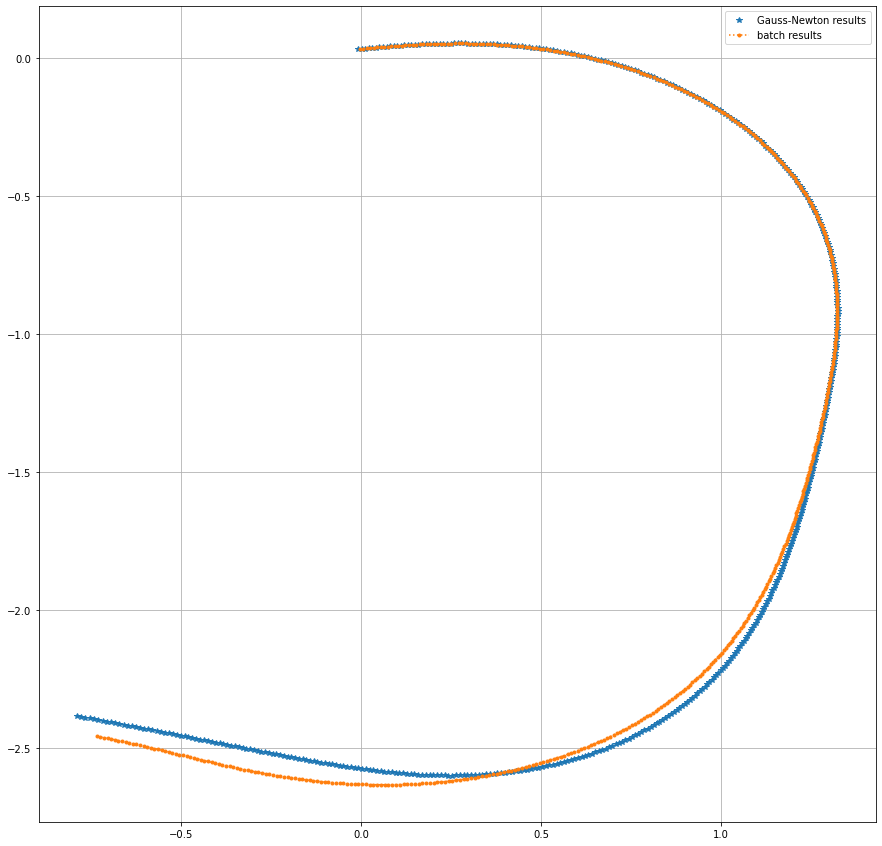

In [14]:
plt.figure(figsize=(15,15))
# plt.plot(filtered_states_newton.mean[:,0], "--", label="Newton results" )
plt.plot(iterated_smoother_results.mean[:,0], iterated_smoother_results.mean[:,1], "*", label = "Gauss-Newton results")
plt.plot(x_batch[:,0], x_batch[:,1], ".:", label = "batch results")
# plt.title("state sresult")
plt.grid()
plt.legend();